In [1]:
import collections

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

/Users/kai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 1. Load Data

In [3]:
df_friday = pd.read_excel('Your_Dataset.xlsx')

## 2. EDA and Data Processing

In [4]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [5]:
df_friday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 18 columns):
contract_nr                 27950 non-null int64
sf_class_tpl                27950 non-null object
sf_class_fc                 27950 non-null object
age_insured_person          27950 non-null int64
policy_start                27940 non-null object
tariff_type                 27950 non-null object
type_of_insurance           27950 non-null object
comprehensive_product       20355 non-null object
fc_deductible               27950 non-null int64
pc_deductible               27950 non-null int64
payment_interval            27950 non-null object
insured_parties             27950 non-null object
profession_group            27950 non-null object
car_age_at_purchase         27950 non-null int64
car_age_contract_start      27950 non-null int64
annual_mileage              27950 non-null int64
risk_predictor_zip_code     27948 non-null float64
number_of_payment_faults    4789 non-null float

In [6]:
df_friday.shape

(27950, 18)

### 'sf_class_tpl' 

In [31]:
df_friday['sf_class_tpl'].describe()

count     27950
unique       48
top       SF1/2
freq       3564
Name: sf_class_tpl, dtype: object

In [32]:
df_friday['sf_class_tpl'].unique()

array(['SF1/2', 'SF31', 'SF5', 'SF15', 'SF17', 'SF7', 'SF9', 'SF3',
       'SF19', 'SF4', 'SF11', 'SF27', 'SF14', 'SF36', 'SF21', 'SF6',
       'SF18', 'SF2', 'SF22', 'SF16', 'SF29', 'SF25', 'SF33', 'SF23',
       'SF26', 'SF12', 'SF8', 'SF10', 'SF35', 'SF24', 'SF1', 'SF13', 0,
       'SF34', 'SF20', 'SF30', 'SF39', 'SF32', 'SF28', 'SF37', 'M',
       'SF40', 'SF44', 'SF38', 'SF41', 'SF43', 'SF42', 'S'], dtype=object)

In [33]:
len(df_friday['sf_class_tpl'].unique())

48

In [34]:
df_friday[df_friday['sf_class_tpl'].isnull()].shape

(0, 18)

### 'sf_class_fc'

In [38]:
df_friday['sf_class_fc'].describe()

count     27950
unique       48
top       SF1/2
freq       3677
Name: sf_class_fc, dtype: object

In [39]:
df_friday['sf_class_fc'].unique()

array(['SF1/2', 'SF31', 'SF5', 'SF15', 'SF18', 'SF13', 'SF9', 'SF3',
       'SF14', 'SF4', 'SF11', 'SF27', 'SF20', 'SF36', 'SF30', 'SF16',
       'SF7', 'SF22', 'SF29', 'SF25', 'SF2', 'SF33', 'SF23', 'SF26',
       'SF12', 'SF19', 'SF8', 'SF10', 'SF35', 'SF6', 'SF24', 'SF1',
       'SF21', 0, 'SF34', 'SF17', 'SF39', 'SF32', 'SF28', 'SF37', 'M',
       'SF44', 'SF38', 'SF43', 'SF41', 'SF42', 'SF40', 'S'], dtype=object)

In [40]:
len(df_friday['sf_class_fc'].unique())

48

In [41]:
df_friday[df_friday['sf_class_fc'].isnull()].shape

(0, 18)

### 'age_insured_person'

In [42]:
df_friday['age_insured_person'].describe()

count   27950.000
mean       45.835
std        13.811
min        18.000
25%        35.000
50%        44.000
75%        56.000
max        93.000
Name: age_insured_person, dtype: float64

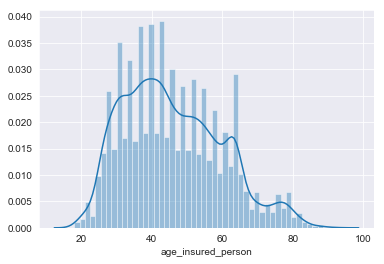

In [43]:
sns.distplot(df_friday['age_insured_person'])

In [44]:
#skewness and kurtosis
print("Skewness: %f" % df_friday['age_insured_person'].skew())

Skewness: 0.479795


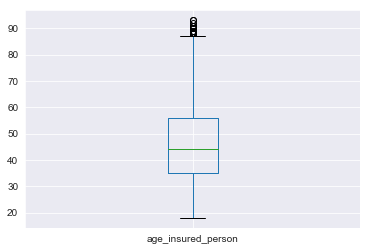

In [45]:
df_friday[['age_insured_person']].boxplot()
pyplot.show()

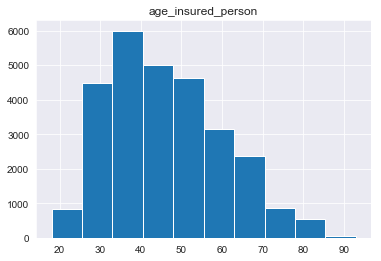

In [46]:
df_friday[['age_insured_person']].hist()
pyplot.show()

In [47]:
print(df_friday['age_insured_person'].mean())
print(df_friday['age_insured_person'].median())

45.83545617173524
44.0


In [48]:
df_friday[df_friday['age_insured_person'].isnull()].shape

(0, 18)

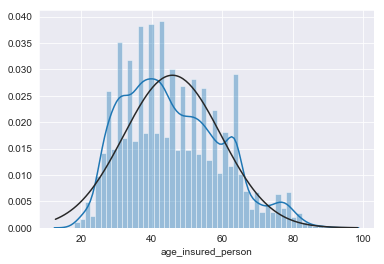

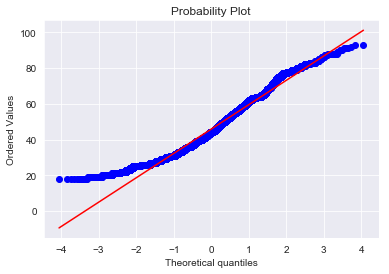

In [49]:
sns.distplot(df_friday['age_insured_person'], fit=norm);
fig = plt.figure()

# https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html
res = stats.probplot(df_friday['age_insured_person'], plot=plt)

### 'policy_start'

In [50]:
df_friday['policy_start'].describe()

count     27940
unique        2
top         YOB
freq      16114
Name: policy_start, dtype: object

In [51]:
df_friday['policy_start'].unique()

array(['YOB', 'YEB', nan], dtype=object)

In [52]:
df_friday[df_friday['policy_start'].isnull()].shape

(10, 18)

### 'tariff_type'

In [53]:
df_friday['tariff_type'].describe()

count        27950
unique           2
top       Original
freq         24009
Name: tariff_type, dtype: object

In [54]:
df_friday['tariff_type'].unique()

array(['Original', 'Pay per km'], dtype=object)

In [55]:
df_friday[df_friday['tariff_type'].isnull()].shape

(0, 18)

### 'type_of_insurance'

In [58]:
df_friday['type_of_insurance'].describe()

count                 27950
unique                    3
top       Change of Insurer
freq                  19349
Name: type_of_insurance, dtype: object

In [59]:
df_friday['type_of_insurance'].unique()

array(['New Vehicle', 'Change of Insurer', 'First Vehicle'], dtype=object)

In [60]:
df_friday[df_friday['type_of_insurance'].isnull()].shape

(0, 18)

### 'comprehensive_product'

In [61]:
df_friday['comprehensive_product'].describe()

count     20355
unique        2
top          VK
freq      14147
Name: comprehensive_product, dtype: object

In [62]:
df_friday['comprehensive_product'].unique()

array([nan, 'VK', 'TK'], dtype=object)

In [63]:
df_friday[df_friday['comprehensive_product'].isnull()].shape

(7595, 18)

- ### Missing Data

#### Check percentage of missing data

If more than 50% of the data is missing, we should delete the corresponding variable and pretend it never existed. 

In [17]:
total = df_friday.isnull().sum().sort_values(ascending=False)
percent = (df_friday.isnull().sum()/df_friday.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data


,Total,Percent
number_of_payment_faults,23161,4.836
comprehensive_product,7595,0.373
policy_start,10,0.000
risk_predictor_zip_code,2,0.000
sf_class_tpl,0,0.000
sf_class_fc,0,0.000
age_insured_person,0,0.000
tariff_type,0,0.000
type_of_insurance,0,0.000
fc_deductible,0,0.000


Text(0.5, 1.0, 'Percent missing data by feature')

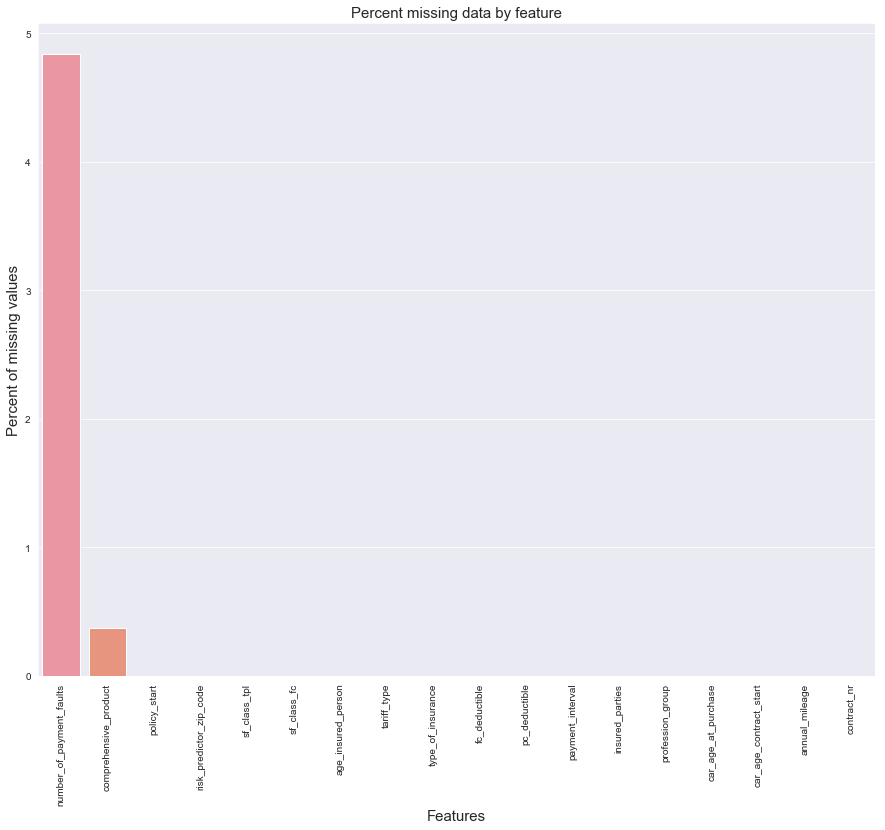

In [18]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=percent.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### 2.1 analyse target 'sf_class_tpl' 

In [7]:
df_friday['sf_class_tpl'].describe()

count     27950
unique       48
top       SF1/2
freq       3564
Name: sf_class_tpl, dtype: object

In [9]:
df_friday['sf_class_tpl'].unique()

array(['SF1/2', 'SF31', 'SF5', 'SF15', 'SF17', 'SF7', 'SF9', 'SF3',
       'SF19', 'SF4', 'SF11', 'SF27', 'SF14', 'SF36', 'SF21', 'SF6',
       'SF18', 'SF2', 'SF22', 'SF16', 'SF29', 'SF25', 'SF33', 'SF23',
       'SF26', 'SF12', 'SF8', 'SF10', 'SF35', 'SF24', 'SF1', 'SF13', 0,
       'SF34', 'SF20', 'SF30', 'SF39', 'SF32', 'SF28', 'SF37', 'M',
       'SF40', 'SF44', 'SF38', 'SF41', 'SF43', 'SF42', 'S'], dtype=object)